# IDC Tutorial: Getting started on working with slide microscopy data in IDC

The purpose of this notebook is to demonstrate how the [Imaging Data Commons (IDC)](https://learn.canceridc.dev/getting-started-with-idc) can be used to work with whole slide images (WSIs).

Besides radiology, slide microscopy is the second major imaging modality in the IDC. Slide microscopy images show **thin sections of tissue samples** (e.g., from a resected tumor) at microscopic resolution. They provide a unique glimpse into cellular architecture and function that is essential for diagnosing complex diseases like cancer. Computerized analysis makes the assessment of slide microscopy images more reproducible and less time consuming and it enables the extraction of novel digital biomarkers from tissue images.

This tutorial provides a **15-minute** introduction to the way slide microscopy data is organized (within the IDC) and demonstrates how to **examine available data and build a data cohort** for further analysis.
It also provides an example of the **application of deep learning (DL)** to computational pathology analysis. In particular, a pre-trained model made available in the context of the publication [The NCI Imaging Data Commons as a platform for reproducible research in computational pathology](https://doi.org/10.1016/j.cmpb.2023.107839) is used to **classify lung tissue regions** into either non-neoplastic (normal), adenocarcinoma (LUAD), or squamous cell carcinoma (LSCC) tissue. A similar notebook with an acompanying slide deck was part of a tutorial given at ISBI 2024 and can be found [here](https://github.com/ImagingDataCommons/IDC-Tutorials/wiki/ISBI2024).

For a more comprehensive tutorial including training of a tissue classification model on IDC-hosted slide microscopy data, see the Github repository [idc-comppath-reproducibility](https://github.com/ImagingDataCommons/idc-comppath-reproducibility).  
  
To learn more about the IDC, please visit the [IDC user guide](https://learn.canceridc.dev/getting-started-with-idc).

If you have any questions, bug reports, or feature requests please feel free to contact us at the [IDC discussion forum](https://discourse.canceridc.dev/)!

--
*Initial version: August 2024*

# Prerequisites


**Step 1: Save notebook to Google Drive (optional)**: We suggest to copy this notebook in your private Google Drive (by clicking on the respective button in the headline of this notebook), which takes you to a new tab and ensures that changes and outputs are continously saved.

**Step 2: Ensure package dependencies:** We need to install additional libraries. These are:
* **[idc-index](https://pypi.org/project/idc-index/):** facilitates queries of the basic metadata and download of DICOM files hosted by the IDC.
* **[wsidicom](https://pypi.org/project/wsidicom/):** provides functionality to open and extract image or metadata from WSIs.
* **[openslide](https://openslide.org/):** well established tool offering functionality to work with WSIs and recently added support for DICOM format.

In addition, we select a tensoflow version, which is compatible with our pre-trained model's format.

In [1]:
%%capture
!pip3 install wsidicom==0.20.5 idc-index>=0.6.3 tensorflow==2.15

In [2]:
%%capture
# Installation Openslide 4.0.0 which supports DICOM
!apt install software-properties-common
!add-apt-repository ppa:openslide/openslide -y
!apt install openslide-tools # for OpenSlide
!apt install python3-openslide # for OpenSlide Python

**Step 3: Clone utility code:** We provide some utility code for more complex operations, which is also available open source along with this notebook. In the cell below, the code is cloned to the current Colaboratory instance.

In [3]:
!git clone https://github.com/ImagingDataCommons/IDC-Tutorials.git

Cloning into 'IDC-Tutorials'...
remote: Enumerating objects: 2268, done.
remote: Counting objects: 100% (787/787), done.
remote: Compressing objects: 100% (285/285), done.
remote: Total 2268 (delta 535), reused 688 (delta 488), pack-reused 1481 (from 1)
Receiving objects: 100% (2268/2268), 123.09 MiB | 15.27 MiB/s, done.
Resolving deltas: 100% (1346/1346), done.
Updating files: 100% (97/97), done.


# Imports

In [4]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from PIL import Image
from tqdm.auto import tqdm
from tensorflow.keras.models import load_model
from IPython.display import IFrame
from idc_index import index

# Load utility code
import sys
sys.path.append('/content/IDC-Tutorials/notebooks/labs/')
from idc_isbi2024_utils.utils import create_slides_metadata
from idc_isbi2024_utils.batch_iterator import BatchIterator
from idc_isbi2024_utils.predictions import Predictions
from idc_isbi2024_utils.heatmap import plot_colormap_legend, generate_heatmap
from idc_isbi2024_utils.global_variables import CLASS_LABEL_TO_INDEX_MAP, NUM_CLASSES

ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
  File "<frozen importlib._bootstrap>", line 1050, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1027, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1004, in _find_and_load_unlocked
ModuleNotFoundError: No module named 'pylibjpeg'
ERROR:pydicom.pixels.utils:No module named 'pylibjpeg'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pydicom/pixels/utils.py", line 1274, in _passes_version_check
    module = importlib.import_module(package_name, "__version__")
  File "/usr/lib/python3.10/importlib/__init__.py", line 126, i

ImportError: cannot import name 'JPEGLosslessP14' from 'pydicom.uid' (/usr/local/lib/python3.10/dist-packages/pydicom/uid.py)

# Part 1: Introduction to whole slide imaging with DICOM

To optimize both storage and retrieval efficiency, WSI are typically stored in a pyramidal format. In this structure, the full resolution image forms the base layer, while progressively downsampled versions of the image form the higher layers as depicted on the left side of the figure below.

The IDC employs the [DICOM standard](https://www.dicomstandard.org/) for data representation and management including WSI. As shown in the figure below on the right side, a WSI pyramid corresponds to a `Series` of DICOM (SOP) instances with each individual DICOM instance being stored as a separate DICOM file. Multiple DICOM `Series` can be organized in a DICOM `Study`, and similarly multiple DICOM `Studies` can belong to one `Patient`.

<img src="https://github.com/DanielaSchacherer/IDC-Tutorials/blob/pathology_notebook_update/notebooks/pathomics/DICOM_WSI_overview.png?raw=1" alt="Description" width="1000"/>

# Part 2: How to search whole slide data on IDC

For most computational pathology experiments, the first step is to select a cohort of WSIs filtering by the desired metadata attributes.

The IDC maintains DICOM (and non-DICOM) metadata for all its image data in index tables. These can be accessed programmatically by executing BigQuery statements. The IDC-maintained Python package `idc-index` provides a simplified interface to the most common metadata and allows for quick subsetting and download of IDC data. Below, we give a short introduction to `idc-index` from the perspective of a pathology user. As a basis for this, we recommend to read through the following sections of this [introductory notebook](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part2_searching_basics.ipynb): `Downloading data from IDC`, `Searching IDC data` and `Working with the search results > Downloading selected images` first.


In [8]:
idc_client = index.IDCClient() # set-up idc_client
display(pd.DataFrame.from_dict(idc_client.indices_overview, orient='index')) # see available index tables

,description,installed,url
index,Main index containing one row per DICOM series.,True,None
previous_versions_index,index containing one row per DICOM series from...,True,None
sm_index,DICOM Slide Microscopy series-level index.,False,https://github.com/ImagingDataCommons/idc-inde...
sm_instance_index,DICOM Slide Microscopy instance-level index.,False,https://github.com/ImagingDataCommons/idc-inde...
clinical_index,Index of clinical data accompanying the availa...,False,https://idc-open-metadata.s3.amazonaws.com/big...


While the aforementioned introductory notebook queries the main index table, which is available by default, there is indeed additional index tables such as the `clinical_index` for non-DICOM data or slide microscopy specific tables (indicated by the prefix **sm**). While `sm_index` contains pathology specific attributes on a `Series`-level `sm_instance_index` contains pathology specific attributes on an instance-level.

The following code shows how to fetch additional index tables and list the metadata attributes that come with them.  

In [10]:
idc_client.fetch_index('sm_index')
idc_client.fetch_index('sm_instance_index')
display(pd.DataFrame.from_dict(idc_client.indices_overview, orient='index'))

,description,installed,url
index,Main index containing one row per DICOM series.,True,None
previous_versions_index,index containing one row per DICOM series from...,True,None
sm_index,DICOM Slide Microscopy series-level index.,True,https://github.com/ImagingDataCommons/idc-inde...
sm_instance_index,DICOM Slide Microscopy instance-level index.,True,https://github.com/ImagingDataCommons/idc-inde...
clinical_index,Index of clinical data accompanying the availa...,False,https://idc-open-metadata.s3.amazonaws.com/big...


In [22]:
display(idc_client.sm_index.head())

,SeriesInstanceUID,embeddingMedium_CodeMeaning,embeddingMedium_code_designator_value_str,tissueFixative_CodeMeaning,tissueFixative_code_designator_value_str,staining_usingSubstance_CodeMeaning,staining_usingSubstance_code_designator_value_str,min_PixelSpacing_2sf,max_TotalPixelMatrixColumns,max_TotalPixelMatrixRows,ObjectiveLensPower,primaryAnatomicStructure_code_designator_value_str,primaryAnatomicStructure_CodeMeaning,primaryAnatomicStructureModifier_code_designator_value_str,primaryAnatomicStructureModifier_CodeMeaning,illuminationType_code_designator_value_str,illuminationType_CodeMeaning
0,1.3.6.1.4.1.5962.99.1.252626659.900932168.1640...,[],[],[],[],"[water soluble eosin stain, hematoxylin stain]","[SCT:36879007, SCT:12710003]",0.00049,23903,23079,20,SCT:39607008,Lung,SCT:86049000,"Neoplasm, Primary",DCM:111744,Brightfield illumination
1,1.3.6.1.4.1.5962.99.1.283273496.616241917.1640...,[],[],[],[],"[hematoxylin stain, water soluble eosin stain]","[SCT:12710003, SCT:36879007]",0.00049,33863,30549,20,None,None,None,None,DCM:111744,Brightfield illumination
2,1.3.6.1.4.1.5962.99.1.289045102.264665735.1640...,[],[],[],[],"[hematoxylin stain, water soluble eosin stain]","[SCT:12710003, SCT:36879007]",0.00049,17927,15754,20,SCT:35039007,Uterus,SCT:17621005,Normal,DCM:111744,Brightfield illumination
3,1.3.6.1.4.1.5962.99.1.251869567.517915545.1640...,[],[],[],[],"[water soluble eosin stain, hematoxylin stain]","[SCT:36879007, SCT:12710003]",0.00065,9227,8190,<NA>,SCT:39607008,Lung,SCT:17621005,Normal,DCM:111744,Brightfield illumination
4,1.3.6.1.4.1.5962.99.1.164890354.1414313345.164...,[],[],[],[],"[water soluble eosin stain, hematoxylin stain]","[SCT:36879007, SCT:12710003]",0.00050,21912,21050,20,SCT:64033007,Kidney,SCT:86049000,"Neoplasm, Primary",DCM:111744,Brightfield illumination


In [25]:
display(idc_client.sm_instance_index[:1])

,SOPInstanceUID,SeriesInstanceUID,embeddingMedium_CodeMeaning,embeddingMedium_code_designator_value_str,tissueFixative_CodeMeaning,tissueFixative_code_designator_value_str,staining_usingSubstance_CodeMeaning,staining_usingSubstance_code_designator_value_str,PixelSpacing_0,ImageType,TransferSyntaxUID,instance_size,crdc_instance_uuid
0,1.3.6.1.4.1.5962.99.1.528744472.1087975700.164...,1.3.6.1.4.1.5962.99.1.528744472.1087975700.164...,[Paraffin wax],[SCT:311731000],[Formalin],[SCT:431510009],"[hematoxylin stain, water soluble eosin stain]","[SCT:12710003, SCT:36879007]",0.024075,"[DERIVED, PRIMARY, THUMBNAIL, RESAMPLED]",1.2.840.10008.1.2.1,1852990,12ae9755-34a4-4233-86c4-f2b9fb38a113


In [20]:
print(f'Attributes in sm_index: \n{idc_client.sm_index.dtypes}\n')
print(f'Attributes in sm_instance_index: \n{idc_client.sm_instance_index.dtypes}')

Attributes in sm_index: 
SeriesInstanceUID                                              object
embeddingMedium_CodeMeaning                                    object
embeddingMedium_code_designator_value_str                      object
tissueFixative_CodeMeaning                                     object
tissueFixative_code_designator_value_str                       object
staining_usingSubstance_CodeMeaning                            object
staining_usingSubstance_code_designator_value_str              object
min_PixelSpacing_2sf                                          float64
max_TotalPixelMatrixColumns                                     Int64
max_TotalPixelMatrixRows                                        Int64
ObjectiveLensPower                                              Int64
primaryAnatomicStructure_code_designator_value_str             object
primaryAnatomicStructure_CodeMeaning                           object
primaryAnatomicStructureModifier_code_designator_value_str     ob

In case of DICOM-derived attributes the attributes' naming is corresponding directly to the name of the respective DICOM attribute plus a suffix, which indicates that the column either contains `CodeSchemeDesignator` and `CodeValue` or `CodeMeaning`. If this is new to you, a brief explanation into this three-value based coding scheme in DICOM can be found at https://learn.canceridc.dev/dicom/coding-schemes.  

With the index tables being simply pandas DataFrames, the easiest way to get an overview of the values in the index tables are basic pandas operations:

The following query joins the general metadata table with the slide microscopy index (`sm_index`) and selects only slides from the cptac lung collections. After that, a random selection of three slides will be taken out of the result.



In [ ]:
query = '''
SELECT
    index.SeriesInstanceUID as digital_slide_id,
    index.StudyInstanceUID as case_id,
    (REPLACE (REPLACE(index.collection_id, 'cptac_luad', 'luad'), 'cptac_lscc', 'lscc')) AS cancer_subtype,
    -- The 'tissue_types' indicates whether a slides contains normal, tumor or other tisse.
    sm_index.primaryAnatomicStructureModifier_CodeMeaning as tissue_type
FROM
    index
JOIN
    sm_index ON sm_index.SeriesInstanceUID = index.SeriesInstanceUID
WHERE
    index.collection_id = 'cptac_luad' OR index.collection_id = 'cptac_lscc'
'''

example_slides_df = idc_client.sql_query(query)
selection = example_slides_df.sample(n=3, random_state=3)

# Part 2: How to access and read whole-slide images from IDC

In the following, `idc-index` is used to download the previously selected slides to our Colaboratory instance.

In [ ]:
example_slides_dir = '/content/example_slides'
os.makedirs(example_slides_dir, exist_ok=True)

idc_client.download_from_selection(downloadDir=example_slides_dir,
                                   seriesInstanceUID=selection['digital_slide_id'].tolist(), dirTemplate='%SeriesInstanceUID')

Using a utility function, we re-arrage the metadata obtained from IDC and add the slides' local paths and the reference classes for Part 3 of this notebook.

In [ ]:
slides_metadata = create_slides_metadata(selection, example_slides_dir) # The metadata are reorganized and reference classes are added.
display(slides_metadata)

,digital_slide_id,case_id,cancer_subtype,tissue_type,local_path,reference_class_label
1.3.6.1.4.1.5962.99.1.239436341.426556033.1640916976181.2.0,1.3.6.1.4.1.5962.99.1.239436341.426556033.1640...,2.25.179013521050026533388058568595679659550,luad,tumor,/content/example_slides/1.3.6.1.4.1.5962.99.1....,luad
1.3.6.1.4.1.5962.99.1.260119817.1889210799.1640937659657.2.0,1.3.6.1.4.1.5962.99.1.260119817.1889210799.164...,2.25.326924841153682415134838745653358644184,luad,normal,/content/example_slides/1.3.6.1.4.1.5962.99.1....,normal
1.3.6.1.4.1.5962.99.1.234718894.2126732241.1640912258734.2.0,1.3.6.1.4.1.5962.99.1.234718894.2126732241.164...,2.25.41271271351062721460339920319914617399,lscc,tumor,/content/example_slides/1.3.6.1.4.1.5962.99.1....,lscc


Any slide can be viewed and explored in detail using the [IDC Slim viewer](https://github.com/ImagingDataCommons/slim). In the following, we embed the viewer that opens the URL for the selected series into the output cell.

In [ ]:
viewer_url = idc_client.get_viewer_URL(seriesInstanceUID=slides_metadata.iloc[0]['digital_slide_id'])
IFrame(viewer_url, width=1000, height=500)

There are multiple Python libraries available that can open and process DICOM WSIs. As an example, we will now quickly check available levels and open an overview image with **wsidicom**, a library specifically targeted to work with the DICOM format:

Tissue type:  luad
Available levels: 
Level: 0, size: Size(width=33863, height=42869) px, mpp: SizeMm(width=0.4942, height=0.4942) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7cc75461c3a0>])
Level: 2, size: Size(width=8465, height=10717) px, mpp: SizeMm(width=1.976975144714, height=1.976975144714) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7cc754553520>])
Level: 4, size: Size(width=2116, height=2679) px, mpp: SizeMm(width=7.908834877126999, height=7.908834877126999) um/px Instances: [0]: default z: 0.0 default path: 1 ImageData WsiDicomFileImageData of files odict_values([<wsidicom.file.io.wsidicom_reader.WsiDicomReader object at 0x7cc75358cc70>])


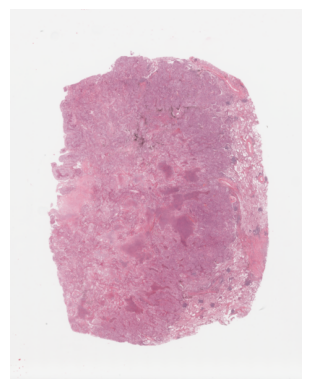

In [ ]:
from wsidicom import WsiDicom

# Open slide with wsidicom
slide = WsiDicom.open(slides_metadata.iloc[0]['local_path'])
print('Tissue type: ', slides_metadata.iloc[0]['reference_class_label'])
# Check which levels are available
print('Available levels: ')
for level in slide.levels:
    print(level)
# Plot overview image
plt.imshow(slide.read_thumbnail(size=(512,512)))
plt.axis('off')
plt.show()

The same thing can be done in a very similar way with **openslide**, that might be more familiar to many working with pathology images as it supports among DICOM a wide range of other file formats:

Tissue type:  luad
Number of available levels: 3
Dimensions of available levels: ((33863, 42869), (8465, 10717), (2116, 2679))
Downsampling factors of available levels: (1.0, 4.000223855083705, 16.002587248296102)


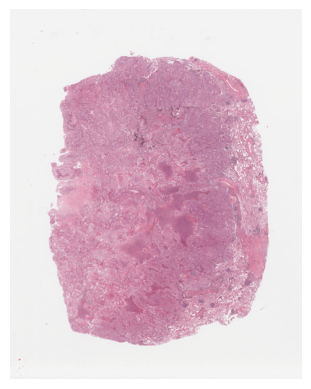

In [ ]:
from openslide import OpenSlide

# Open slide with openslide
file_path = os.path.join(slides_metadata.iloc[0]['local_path'], os.listdir(slides_metadata.iloc[0]['local_path'])[0])
slide = OpenSlide(file_path)
print('Tissue type: ', slides_metadata.iloc[0]['reference_class_label'])
# Check which levels are available
print(f'Number of available levels: {slide.level_count}')
print(f'Dimensions of available levels: {slide.level_dimensions}')
print(f'Downsampling factors of available levels: {slide.level_downsamples}')
# Plot overview image
plt.imshow(slide.get_thumbnail(size=(512,512)))
plt.axis('off')
plt.show()

To learn about the many more capabilities of wsidicom and openslide, we refer to the respective documentations:
- WsiDicom documentation: https://github.com/imi-bigpicture/wsidicom
- OpenSlide Python documentation: https://openslide.org/api/python/

If in the end you can't find your attribute of interest in the idc-index, check out [this notebook](https://github.com/ImagingDataCommons/IDC-Tutorials/blob/master/notebooks/getting_started/part3_exploring_cohorts.ipynb) to learn how to search **all** of the metadata accompanying IDC using Google BigQuery.

Cohort selection is done easiest by executing SQL-like statements using the Python package `idc-index` against different index tables, which list all available DICOM `Series` or files (rows) with the corresponding available metadata atrributes (columns).

# Part 3: Application example -- Pre-trained model inference

The TCGA-trained model that we use here was made available open source as part of the publication [The NCI Imaging Data Commons as a platform for reproducible research in computational pathology](https://doi.org/10.1016/j.cmpb.2023.107839). The specific model used here is a demo version, meaning that it was trained using slides at reduced magnification (pixel spacing of 0.002 mm/px instead of 0.001 mm/px) and will thus also be applied to slides at this resolution. The model is available as Github release asset and can be retrieved via curl.

## Prediction
**Prediction** is performed in a single sequential pass over the data. Each slide is accessed one after another, tiled and a prediction is made for each tile showing tissue (as determined by the `is_foreground` function). Tiles are not stored on the VM during this process.

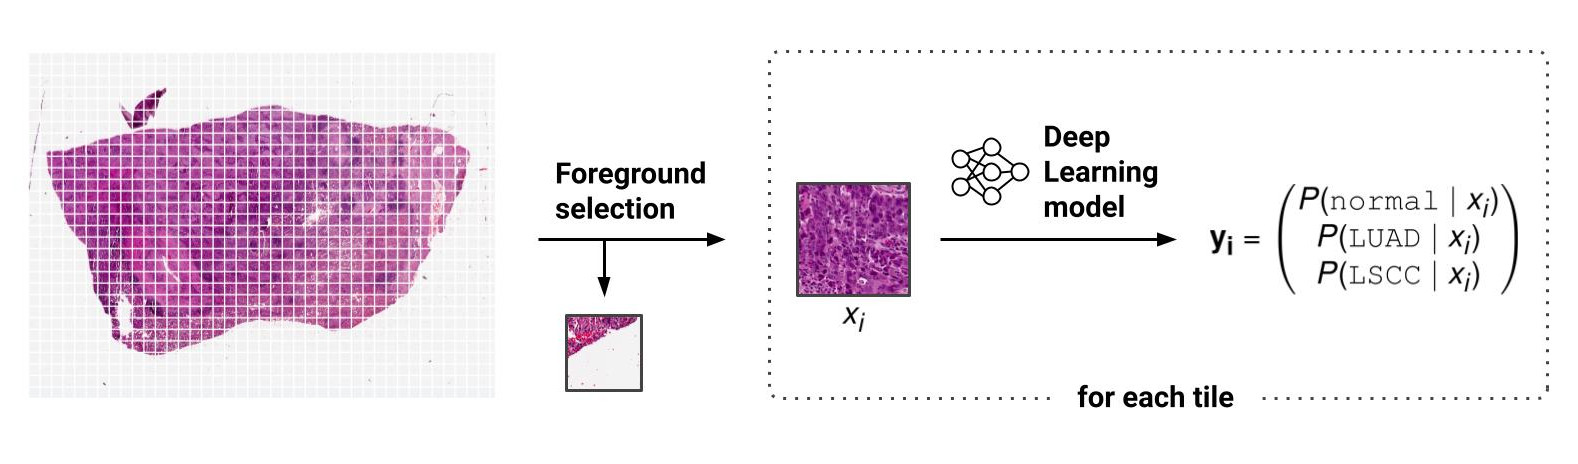

In [ ]:
LEVEL = 2
TILE_SIZE = 128 # in px
MODEL_URL = 'https://api.github.com/repos/ImagingDataCommons/idc-comppath-reproducibility/releases/assets/98547212'
MODEL_FILE_PATH = './tcga_pretrained_model128.zip'

In [ ]:
!curl --progress-bar -LJO \
   -H "Accept: application/octet-stream" \
   $MODEL_URL

!unzip -n $MODEL_FILE_PATH

############################################################################################# 100.0%
Archive:  ./tcga_pretrained_model128.zip
   creating: tcga_pretrained_model128/
  inflating: tcga_pretrained_model128/keras_metadata.pb  
  inflating: tcga_pretrained_model128/saved_model.pb  
   creating: tcga_pretrained_model128/variables/
  inflating: tcga_pretrained_model128/variables/variables.index  
  inflating: tcga_pretrained_model128/variables/variables.data-00000-of-00001  
   creating: tcga_pretrained_model128/assets/


In [ ]:
# Load model
tcga_model_dir = os.path.splitext(MODEL_FILE_PATH)[0]
model = load_model(tcga_model_dir, compile=False)

In [ ]:
def is_foreground(tile: Image.Image) -> bool:
    """
    Function to determine if a tile shows mainly tissue (foreground) or background.
    Returns True if tile shows <= 50% background and False otherwise.
    """
    grey = tile.convert(mode='L')
    thresholded = grey.point(lambda x: 0 if x < 220 else 1, mode='F')
    avg_bkg = np.average(np.array(thresholded))
    return avg_bkg <= 0.5

def predict(model, slides_metadata: pd.DataFrame, coverage: float) -> Predictions:
    """
    Function to perform inference for a certain set of slides using a given pretrained model.
    Returns per-tile predictions as obtained from the model inference plus necessary metadata, e.g.,
    the tile's position in the WSI.
    """
    image_ids = []
    tile_positions = []
    reference_class_indices = []
    predicted_class_probabilities = []

    for index, slide_metadata in tqdm(slides_metadata.iterrows(), total=slides_metadata.shape[0]):
        wsi = WsiDicom.open(slide_metadata['local_path'])
        image_id = slide_metadata['digital_slide_id']
        reference_class_index = CLASS_LABEL_TO_INDEX_MAP[slide_metadata['reference_class_label']]
        batch_iterator = BatchIterator(wsi, TILE_SIZE, LEVEL, is_foreground,
                                    batch_size=32, coverage=coverage)

        for (batch_images, batch_tile_positions) in batch_iterator:
            batch_predicted_class_probabilities = model(batch_images) #model(batch_images).numpy()
            image_ids.extend([image_id] * len(batch_tile_positions))
            tile_positions.extend(batch_tile_positions)
            reference_class_indices.extend([reference_class_index] * len(batch_tile_positions))
            predicted_class_probabilities.extend(batch_predicted_class_probabilities.numpy().tolist())

    dictionary = {'image_id': image_ids, 'tile_position': tile_positions,
            'reference_class_index': reference_class_indices,
            'predicted_class_index': [p.index(max(p)) for p in predicted_class_probabilities],
            'predicted_class_probabilities': predicted_class_probabilities}

    return Predictions(pd.DataFrame(dictionary))

In [ ]:
# Perform prediction
predictions = predict(model, slides_metadata, coverage=1.0)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
display(predictions._predictions.head())

,image_id,tile_position,reference_class_index,predicted_class_index,predicted_class_probabilities
0,1.3.6.1.4.1.5962.99.1.239436341.426556033.1640...,"(26, 67)",1,2,"[0.008204784244298935, 0.025713084265589714, 0..."
1,1.3.6.1.4.1.5962.99.1.239436341.426556033.1640...,"(39, 55)",1,2,"[0.00021618047321680933, 0.42250528931617737, ..."
2,1.3.6.1.4.1.5962.99.1.239436341.426556033.1640...,"(47, 39)",1,2,"[0.0004807528166566044, 0.0766545906662941, 0...."
3,1.3.6.1.4.1.5962.99.1.239436341.426556033.1640...,"(48, 60)",1,2,"[0.07240339368581772, 0.0526147186756134, 0.87..."
4,1.3.6.1.4.1.5962.99.1.239436341.426556033.1640...,"(35, 13)",1,2,"[0.0007635573274455965, 0.009663252159953117, ..."


## Evaluation

**Heatmaps** are generated for visually inspecting the network's predictions for our three slides. The color of each tile in the heatmap corresponds to the class assigned by our model. The hue indicates how confident the network is in this classification. Hereby, a darker hue corresponds to higher confidence. The respective orginal WSI is shown as thumbnail image next to the heatmap. Please be aware, that the analysis results are not perfect because fewer training data with reduced resoltion were used to generate the pre-trained model in order to accelerate execution time.

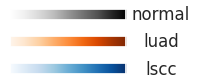

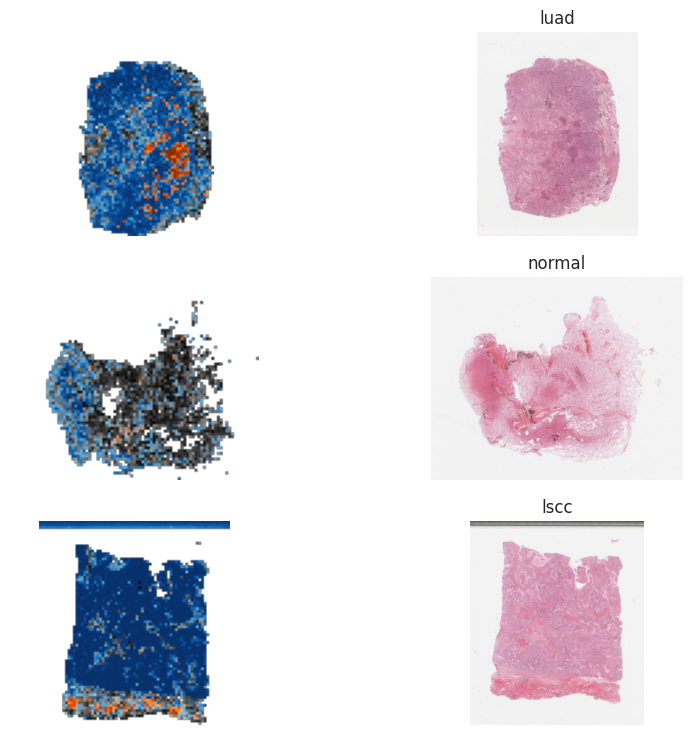

In [ ]:
plot_colormap_legend()
fig, axes = plt.subplots(3, 2, figsize=(10, 9))
for i, (image_id, slide_metadata) in enumerate(slides_metadata.iterrows()):
    wsi = WsiDicom.open(slide_metadata['local_path'])
    thumbnail = wsi.read_thumbnail()
    true_tissue_type = slide_metadata['reference_class_label']
    heatmap = generate_heatmap(predictions, image_id)
    axes[i,0].imshow(heatmap)
    axes[i,1].imshow(thumbnail)
    axes[i,1].set_title(true_tissue_type)
    axes[i,0].axis('off')
    axes[i,1].axis('off')

---
*The results shown here are in whole or part based upon data generated by the The Cancer Genome Atlas (TCGA) Research Network and the National Cancer Institute Clinical Proteomic Tumor Analysis Consortium (CPTAC).*

*Copyright 2024 Fraunhofer MEVIS and Harvard Medical School. Redistribution and use of this notebook, with or without modification, are permitted under the terms of the [3-Clause BSD License](https://opensource.org/licenses/BSD-3-Clause).*